# Solve the network dynamics


In [ ]:
import numpy as np
import pandas as pd
from collections import Counter
from scipy.stats import bernoulli, loguniform
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import networkx as nx
from functools import partial
from pathlib import Path
from tqdm.notebook import tqdm
plt.style.use('seaborn-poster')

## These following have to be customized
PATH_TO_DATA = Path('../data')
# method for solving ODE
METHOD = 'RK45'
# number of days of collection of articles
N_DAYS = 30
TIME_THRESHOLD = 9 # in days

In [ ]:
%matplotlib inline

TODO: describe function.

In [ ]:
def media_recit(G):
    list_c = []
    for node in G.nodes():
        dates_list = [G.nodes()._nodes[j]['timestamp'] for j in G.successors(node)]
        if dates_list != []:
            delta_t = max(dates_list) - G.nodes()._nodes[node]['timestamp']
            dif = delta_t.total_seconds()/(3600*24)
            if dif > TIME_THRESHOLD:
                print(node)
            list_c.append([G.nodes()._nodes[node]['timestamp'].date(),dif])
        else:
            list_c.append([G.nodes()._nodes[node]['timestamp'].date(),0])
    return list_c

The following function is used for solving the ODE.

In [ ]:
def fun(
    t, # timestep
    y, # old state
    pars, # ODE fixed parameters
):
    # Get the old state, numpify it
    y = np.array(y)
    # Separate infected (i) and susceptibles (s)
    i, s = y[:total_articles], y[total_articles:]
    # Get ODE fixed parameters, i.e. lambda and a_ij
    A, lamb = pars
    # Get contacts vectors
    M =  (i * A).sum(axis=1)
    # Get trasmission scusceptibles
    N = lamb * s
    # Get new infected
    Q = N*M
    # Propagate for getting delta infected
    dI = -i + Q
    # Propagate for getting delta susceptible
    dS = -Q
    # Return new state
    return np.hstack((dI,dS))

Function for retrieving infected and suceptibles probabilities for every timestep from the solutions of the ODE.

In [ ]:
def create_dI(sol):
    dI, dS = sol.y[:total_articles, :], sol.y[total_articles:, :]
    return dI, dS

Function for inferring effectively infected articles for every timestep from infected and suceptibles probabilities retrieved from ODE solutions.

In [ ]:
def create_infects(dI,dS):
    dR = 1-dI+dS

    Infects = np.zeros(dI.shape)
    Infects[:,0] = dI[:,0]

    S0 = dS[:,0] - Infects[:,0]
    R0 = np.zeros(dI.shape[0])
    I0 = Infects[:,0]

    for t in range(1,TIMESTEPS):
        a = dI[:,t]*S0
        a[a<0] = 0.0
        a[a>1.0] = 1.0
        b = dR[:,t]*I0
        b[b<0] = 0.0
        b[b>1.0] = 1.0
        I = bernoulli.rvs(a)
        R = bernoulli.rvs(b)

        Infects[:,t] = I0 - R + I
        a = Infects[:,t]

        if len(a[a<0]) > 0:
            b = I0-R
            if len(b[b<0])>0:
                print('ei')


        I0 = Infects[:,t]
        S0 = S0 - I

    return Infects

## Loading data

In [ ]:
files = [
    'dists_triu.csv',
    'info_df.csv',
    'empirical_graph.gpickle',
    'empirical_graph_nodes.csv',
    'graph_original_domains_each_node.txt',
    'graph_complete.csv',
    'i0.csv',
    'dI.csv',
    'Infects.csv',
    ]
stories = [
    'world_russia',
    'world_norway',
    'world_capitol_hill',
]
story_to_elaborate = 0

Retrieve saved graphs and initial values from `graph_init.ipynb`

In [ ]:
with open(PATH_TO_DATA/stories[story_to_elaborate]/files[5]) as file:
    G = np.loadtxt(file, delimiter=",")
G.sum(1)

In [ ]:
O = nx.read_gpickle(PATH_TO_DATA/stories[story_to_elaborate]/files[2])
O

In [ ]:
with open(PATH_TO_DATA/stories[story_to_elaborate]/files[3]) as file:
    nodes = pd.read_csv(file, delimiter=",").drop(['Unnamed: 0'], 1)
nodes.head()

In [ ]:
with open(PATH_TO_DATA/stories[story_to_elaborate]/files[4]) as f:
    domains = f.read().splitlines()
len(domains)

In [ ]:
eig = np.linalg.eig(G)[0].max()
eig

In [ ]:
with open(PATH_TO_DATA/stories[story_to_elaborate]/files[6]) as f:
    i0 = np.loadtxt(f, delimiter=",")
s0 = 1-i0
total_articles = len(i0)
i0

## Finding $\mu$ and $\Delta t$

In [ ]:
a = media_recit(O)
b = [i[1] for i in a]
fig = plt.figure(figsize=(15,8))
plt.hist(b, bins='auto')
plt.plot()
plt.grid()
plt.show()

In [ ]:
DT = 1/np.mean(b)
DT

In [ ]:
TIMESTEPS = int((N_DAYS+1)/DT)
TIMESTEPS

## Finding $\lambda$

In [ ]:
time_list = [O.nodes()._nodes[j]['timestamp'] for j in O.nodes()] 
dic = Counter(time_list)
t0 = min(time_list)
d = []
for pos,i in enumerate(time_list):
    dif = time_list[pos].date() - t0.date()
    d.append(dif.days)
    
dic = Counter(d)
p=[]
q=[]
i=0

while len(q) < max(dic)+1: 
    q.append(dic[i])
    i += 1

print('Max value of infected is {}'.format(max(q)))

fig = plt.figure(figsize=(15,8))
plt.plot(q)
plt.xlabel('time (days)')
plt.ylabel('articles published')
plt.grid()
plt.show()

Solving for some values of $\lambda$ the ODE and retrieving the maximum number of infected for every history.
The proper value of $\lambda$ to use is that for which the maximum number of infected corresponds to the real maximum number of infected.

In [29]:
lambdas = loguniform.rvs(1e-7, 1, size=10)
print(lambdas)
lambdas_iterator = tqdm(
    lambdas,
    leave=True,
    unit='lambdas',
)
y = []
# N_DAYS = 30
# TIMESTEPS = 500
for l in lambdas_iterator:
    f = partial(fun, pars=(G, l))
    sol = solve_ivp(
        fun=f,
        t_span=[0,N_DAYS],
        y0=list(i0)+list(s0),
        method=METHOD,
        t_eval=np.linspace(0,N_DAYS,TIMESTEPS))
    dI, dS = create_dI(sol)
    Infects = create_infects(dI,dS)
    y.append(np.max(Infects.sum(axis=0)))

[1.86529500e-05 1.34858778e-01 1.10244893e-07 3.65056093e-03
 2.53598170e-03 1.21909924e-02 1.10561878e-02 9.78570009e-01
 7.84344252e-07 4.20233033e-05]


  0%|          | 0/10 [00:00<?, ?lambdas/s]

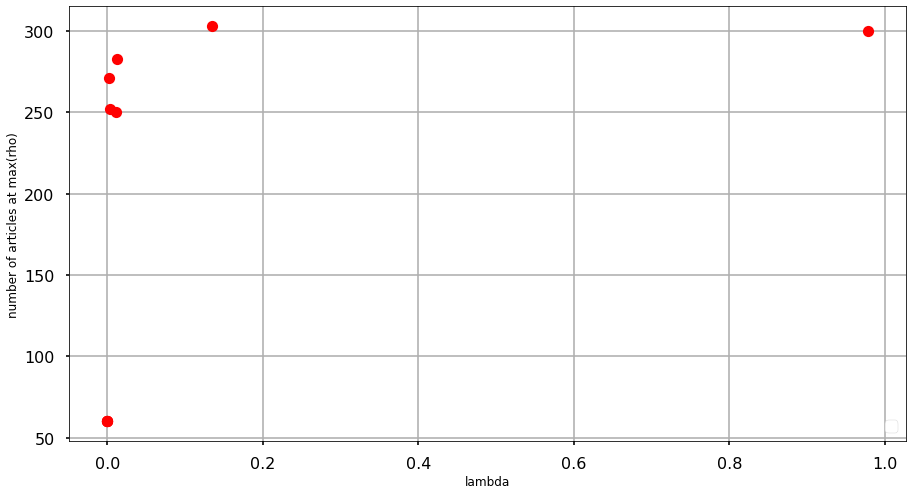

In [30]:
fig = plt.figure(figsize=(15,8))
# plt.plot(len(lambdas)*[8.12645449413e-06], y,'--') # ??
# plt.plot(len(lambdas)*[LAMBDA], y, '--')
plt.legend(['article lambda', 'lambda used'], loc=4)
plt.plot(lambdas,y,'ro')
plt.xlabel('lambda',size=12)
plt.ylabel('number of articles at max(rho)', size=12)
plt.
plt.grid()
plt.savefig(PATH_TO_DATA/'lambda_validation', dpi=300)

Set the value of $\lambda$.

In [ ]:
LAMBDA = 0.06#1.0#0.0000215

Run a simulation for the set value of $\lambda$ for plotting probaibilities' time evolutions.

In [ ]:
f = partial(fun, pars=(G, LAMBDA))
sol = solve_ivp(
    fun=f,
    t_span=[0,N_DAYS],
    y0=list(i0)+list(s0),
    method=METHOD,
    t_eval=np.linspace(0,N_DAYS,TIMESTEPS))
#sol

In [ ]:
sol_infected, sol_susceptibles = sol.y[:total_articles, :], sol.y[total_articles:, :]
articles_to_plot = np.random.choice(range(total_articles), 10)
articles_to_plot = range(total_articles)
plt.figure(figsize = (10, 8))
[plt.plot(sol.t, sol_infected[i, :]) for i in articles_to_plot]
plt.xlabel('time')
plt.ylabel('P(I)')
# plt.legend(['solution {}'.format(i) for i in articles_to_plot])
plt.grid(True)
plt.show()

plt.figure(figsize = (10, 8))
[plt.plot(sol.t, sol_susceptibles[i, :]) for i in articles_to_plot]
plt.xlabel('time')
plt.ylabel('P(S)')
# plt.legend(['solution {}'.format(i) for i in articles_to_plot])
plt.grid(True)
plt.show()

Dump the infected for every timestep form the solution of the ODE.

In [ ]:
dI, dS = create_dI(sol)
Infects = create_infects(dI,dS)
np.savetxt(PATH_TO_DATA/stories[story_to_elaborate]/files[7], dI, delimiter=',')
np.savetxt(PATH_TO_DATA/stories[story_to_elaborate]/files[8], Infects, delimiter=',')
Infects

## Validate the model

Run many simulation of the dynamics to plot them with the real evolution to validate the model.

In [ ]:
# LAMBDA = 0.4
simulations_iterator = tqdm(
    range(0,10),
    leave=False,
    unit='simulations',
)

all_infects = []
for i in simulations_iterator:
    f = partial(fun, pars=(G, LAMBDA))
    sol = solve_ivp(
        fun=f,
        t_span=[0,N_DAYS],
        y0=list(i0)+list(s0),
        method=METHOD,
        t_eval=np.linspace(0,N_DAYS,TIMESTEPS))
    dI, dS = create_dI(sol)
    Infects = create_infects(dI,dS)
    all_infects.append(Infects.sum(axis=0))

In [ ]:
simu_plots = [plt.plot(np.linspace(0,N_DAYS,TIMESTEPS), a, 'b', alpha=0.3) for a in all_infects]
simu_plots[0][0].set_label('simulated')
plt.xlabel('time( days)', size=12)
plt.ylabel('number of articles infected', size=12)
real_plot = plt.plot(q, 'r', label='empirical')
plt.legend()
plt.grid()
plt.show()
plt.savefig(PATH_TO_DATA/'sim_compar.png', dip=300)